# Advanced Lane Finding Project Submission

In [1]:
import cv2
import glob
import imp
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import numpy as np
import os
import pickle
import image_utils
import lane_finding
%matplotlib inline

## Camera Calibration

In order to perform a perspective transform on the image, the distortions introduced by the camera lense must be corrected. The two distortions addressed here are radial and tangential distortion. Radial distortion is the effect where the magnification changes radially as you move away from the image axis. The change in magnification as a function of radial distance can be modeled with a quadratic. Tangential distortion is the effect that happens when the imaging plane is tilted in the x and y directions. This causes half the image to look farther away and half of the image to appear closer.

The method defined to compute the calibration parameters is defined in "image_utils.py" and the code is provided here:

```python
def calibrate_camera(calibration_images, grid=(9,6), plot=False):
    """
    This method will compute the distortion parameters  of the camera using
    the calibration images provided and the grid dimensions.

    :param calibration_images (iterable): calibration images
    :param grid (tuple): chess board dimensions e.g. (10,10)
    :param plot (bool): plot chessboard corners for each calibration image
    :return (tuple): camera matrix and distortion coefficients
    """

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(9,6,0)
    objp = np.zeros((grid[0] * grid[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:grid[0], 0:grid[1]].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for img in calibration_images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            if plot:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
                plt.figure()
                plt.imshow(img)

    # compute camera matrix and distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return mtx, dist
```

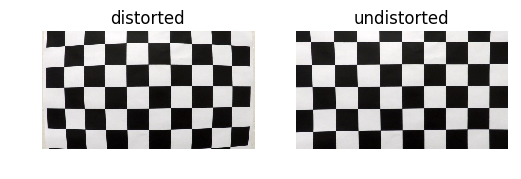

In [2]:
cal_file = 'cal_params.p'

# load calibration images
calibration_images = [mpimg.imread(f) for f in glob.glob("camera_cal/calibration*.jpg")]

if not os.path.exists(cal_file):

    # compute camera matrix and distortion parameters
    mtx, dist = image_utils.calibrate_camera(calibration_images)
    
    with open(cal_file, 'wb') as f:
        pickle.dump((mtx, dist), f)
else:
    with open(cal_file, 'rb') as f:
        mtx, dist = pickle.load(f)

fig, axes = plt.subplots(1,2)

# original image
axes[0].imshow(calibration_images[0])
axes[0].set_title('distorted')
axes[0].axis('off')

# undistorted image
axes[1].imshow(image_utils.undistort(calibration_images[0], mtx, dist))
axes[1].set_title('undistorted')
axes[1].axis('off')

plt.show()

To test the calibration parameters, a calibration image was undistorted. Radial distortion can clearly be seen in the image on the left while the undistorted image does not show any radial distortion. So far so good.

## Perspective Transform

The next part of the pipeline involves applying a perspective transform to produce a birds eye view of the road. To do this we need to identify four points that describe a trapezoid in the image and map these to a rectangle. The trapezoid will be selected using an image of a car driving straight.

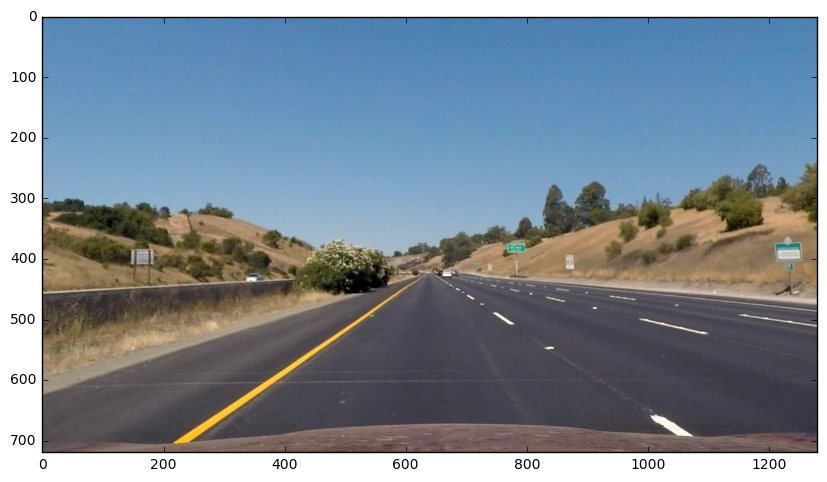

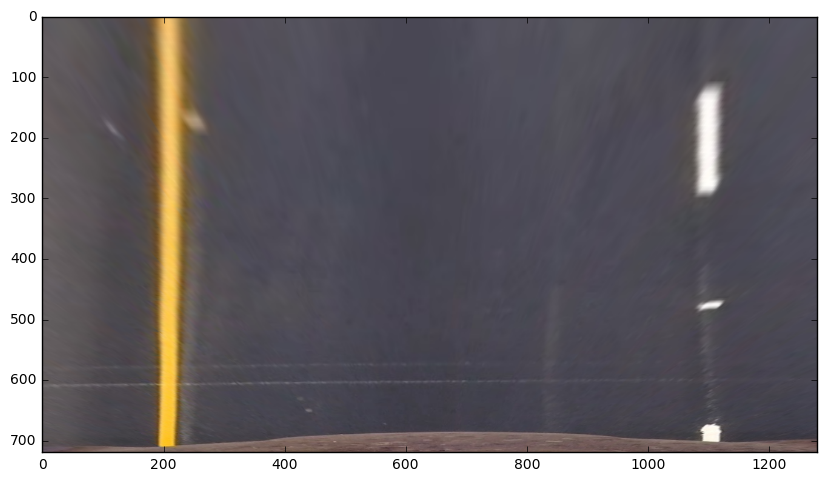

In [3]:
# read images with straight lane lines
straight_imgs = [mpimg.imread(f) for f in glob.glob("test_images/straight*.jpg")]

# start with the first straight line image
straight_img = image_utils.undistort(straight_imgs[0], mtx, dist)

img_shape = straight_img.shape

# image dimensions
height = img_shape[0]
width = img_shape[1]

# window parameters
x_center = width/2
y_top = height/1.5

# source trapezoid coordinates
src = np.float32([(x_center + 0.2*x_center, y_top),
                  (x_center - 0.2*x_center, y_top),
                  (x_center + 0.9*x_center, height),
                  (x_center - 0.9*x_center, height)])

# destination rectangle coordinates
dst = np.float32([(0, 0),
                  (width, 0),
                  (0, height),
                  (width, height)])

# plot original image
fig = plt.figure(figsize=(10,10))
plt.imshow(straight_img)

# apply perspective transform
warped, M, Minv = image_utils.perspective_transform(straight_img, src, dst)
fig = plt.figure(figsize=(10,10))
plt.imshow(warped)

After a significant amount of experimentation it looks like the source and destination points that I have selected above yield a decent perspective transform.

## Color and Gradient Thresholding

To identify the lanes two approaches were used. The first was to isolate the lane colors by applying a threshold to the hue and saturation channels of the image after it has been converted to HLS colorspace. The second approach was to apply thresholds to the following gradient based operations:

* Sobel X
* Sobel Y
* Sobel X & Sobel Y Magnitude
* Sobel X & Sobel Y Direction

A mask is produced for each operation and the final output is the intersection of all of the masks.

In [4]:
img = mpimg.imread("test_images/test4.jpg")
blur = image_utils.guassian_blur(img, kernel_size=5)

def color(hmin, hmax, smin, smax):
    filtered = lane_finding.process_color(blur, hue_thresh=(hmin, hmax), sat_thresh=(smin, smax))
    plt.figure(figsize=(10,10))
    plt.imshow(filtered, cmap='gray')

def gradx(tmin, tmax): 
    filtered = image_utils.abs_sobel_thresh(blur, orient='x', thresh=(tmin, tmax))
    plt.figure(figsize=(10,10))
    plt.imshow(filtered, cmap='gray')
    
def grady(tmin, tmax): 
    filtered = image_utils.abs_sobel_thresh(blur, orient='y', thresh=(tmin, tmax))
    plt.figure(figsize=(10,10))
    plt.imshow(filtered, cmap='gray')

def gradm(tmin, tmax): 
    filtered = image_utils.mag_thresh(blur, sobel_kernel=3, thresh=(tmin, tmax))
    plt.figure(figsize=(10,10))
    plt.imshow(filtered, cmap='gray')
    
def gradd(tmin, tmax): 
    filtered = image_utils.dir_threshold(blur, sobel_kernel=3, thresh=(tmin, tmax))
    plt.figure(figsize=(10,10))
    plt.imshow(filtered, cmap='gray')

slider = lambda tmin, tmax, value: ipywidgets.IntSlider(value=value, min=tmin, max=tmax)
fslider = lambda tmin, tmax, value: ipywidgets.FloatSlider(value=value, min=tmin, max=tmax)

## Hue and Saturation Thresholds

To find the best minimum and maximum values for the hue and saturation thresholds the interactive plot was used below.

<function __main__.color>

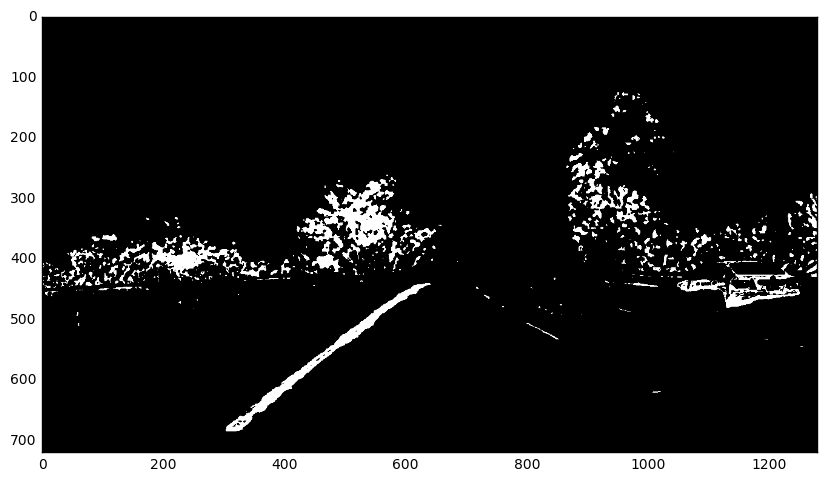

In [5]:
ipywidgets.interact(color, hmin=slider(0,255,0), hmax=slider(0,255,100), smin=slider(0,255,95), smax=slider(0,255,255))

## Sobel X Threshold

To find the best minimum and maximum value for the Sobel X threshold the interactive plot was used below.

<function __main__.gradx>

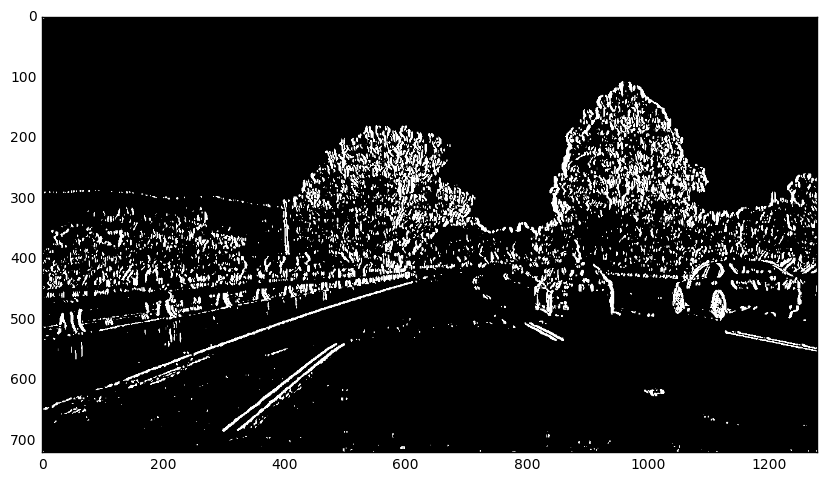

In [6]:
ipywidgets.interact(gradx, tmin=slider(0,255,20), tmax=slider(0,255,255))

## Sobel Y Threshold

To find the best minimum and maximum value for the Sobel Y threshold the interactive plot was used below.

<function __main__.grady>

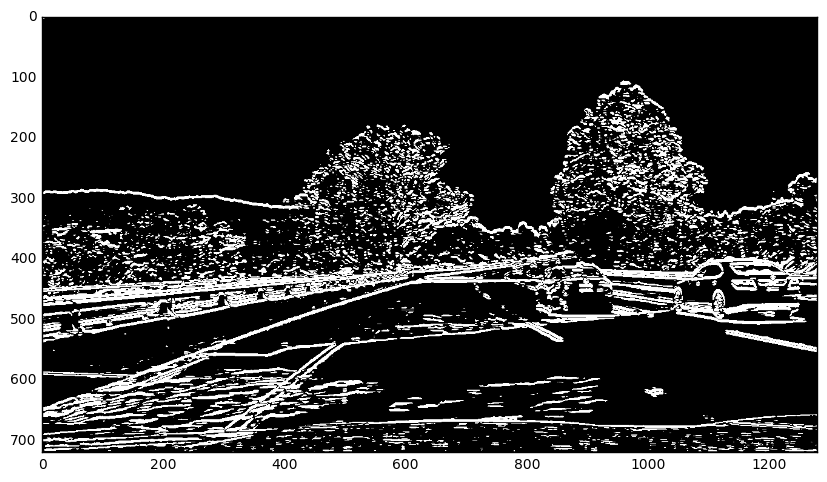

In [7]:
ipywidgets.interact(grady, tmin=slider(0,255,20), tmax=slider(0,255,255))

## Sobel X & Y Magnitude Threshold

To find the best minimum and maximum value for the Sobel X & Y Magnitude threshold the interactive plot was used below.

<function __main__.gradm>

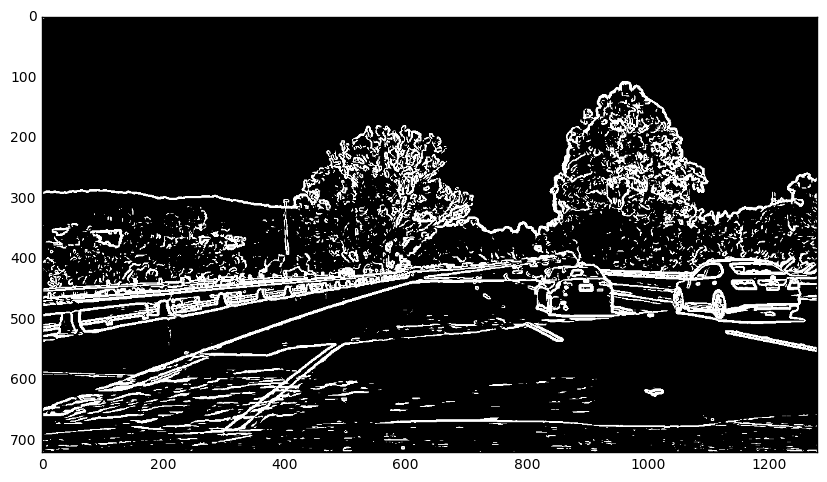

In [8]:
ipywidgets.interact(gradm, tmin=slider(0,255,30), tmax=slider(0,255,255))

## Sobel X & Y Direction Threshold

To find the best minimum and maximum value for the Sobel X & Y threshold the interactive plot was used below.

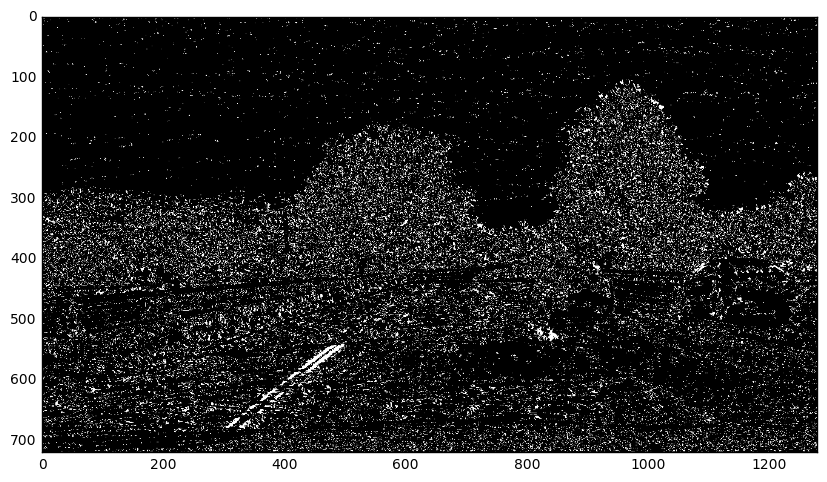

In [9]:
ipywidgets.interact(gradd, tmin=fslider(0,np.pi/2,0.8), tmax=fslider(0,np.pi/2,1.10))

# Feature Identification Pipeline

All of the steps have been completed individually now to identify the lane pixels. Now the next step is to combine them to create a pipline.

* Calibration and Distortion Removal
* Perspective Transform
* Color Thresholding
* Gradient Thresholding

The next step is to create a method that takes the processed image and fits second order polynomials to the right and left lanes. To do this I use the sliding window approach that was covered in the advanced lane finding module with a minor modificiation. The initial histogram was computed using the entire image instead of just half of the image. This made the algorithm more robust to instances where there was no lane markers in the bottom half of the image.

Here is the snippet of code used to find the lanes which can be found in "lane_finding.py":

```python
def find_lanes(img, left_line=None, right_line=None, num_windows=9, window_margin=100, minimum_pixels=50):
    """
    This function applies a sliding window technique to identify the lanes and
    fit a 2nd order polynomial to them.

    :param img: (binary) thresholded and warped image
    :param left_line: (Line) left lane line
    :param right_line: (Line) right lane line
    :param num_windows: (int) number of vertical windows
    :param window_margin: (int) window width +/- margin
    :param minimum_pixels: (int) number of pixels required to move window center
    :return: (tuple) left lane line coefficients, right lane line coefficients,
        left lane curve radius (meters), right lane curve radius (meters)
    """
    if left_line is None:
        left_line = Line()
    if right_line is None:
        right_line = Line()

    # Image dimensions
    image_height, image_width = img.shape

    # Take a histogram of the whole of the image
    histogram = np.sum(img[:, :], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(image_width / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(image_height / num_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image_height - (window + 1) * window_height
        win_y_high = image_height - window * window_height
        win_xleft_low = leftx_current - window_margin
        win_xleft_high = leftx_current + window_margin
        win_xright_low = rightx_current - window_margin
        win_xright_high = rightx_current + window_margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
        nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
        nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minimum_pixels:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minimum_pixels:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    # Extract left and right lane pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Compute line attributes
    left_line.compute_line_properties(leftx, lefty)
    right_line.compute_line_properties(rightx, righty)

    return left_line, right_line
```

In addition to this algorithm I also kept track of line attributes between frames. When computing the fit of the lanes I would use the average of the four previously successful frames. I also performed sanity checks to determine if the current radius and fit measurements were outliers. This class also computes the radius of curvature of the lane.

Here is the class that was used to store lane line state between frames:

```python
class Line():
    """
    This class is used to store state from computations on previous frames.
    """
    FRAME_HISTORY = 5

    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

        # all fit values
        self.all_xfitted = []

        # all radiuses
        self.all_radius = []

    @property
    def bestx(self):
        """Returns fitted polynomial"""
        return np.poly1d(self.best_fit)


    def _reset_state(self):
        """
        Reset current state of line. Note, this does not erase the historical
        parameters.
        """
        self.detected = False
        self.current_fit = [np.array([False])]
        self.allx = None
        self.ally = None


    def _update_state(self, x, y):
        """
        Update line attributes given successful line detection.

        :param x: (ndarray) x coordinates of lane pixels
        :param y: (ndarray) y coordinates of lane pixels
        """
        # Compute curvature of lane
        radius_of_curvature = self._compute_turn_radius(x, y, 360)
        if self.is_radius_outlier(radius_of_curvature):
            self._reset_state()
            return
        self.radius_of_curvature = radius_of_curvature

        # Fit second order polynomial to lane
        new_fit = np.polyfit(y, x, 2)
        if self.is_fit_outlier(new_fit):
            self._reset_state()
            return
        self.current_fit = new_fit

        # Update averaged line properties
        self.recent_xfitted.insert(0, self.current_fit)
        if len(self.recent_xfitted) > self.FRAME_HISTORY:
            self.recent_xfitted.pop()

        self.allx = x
        self.ally = y
        self.best_fit = np.average(self.recent_xfitted, axis=0)

        # Temporary complete histories
        self.all_xfitted.append(new_fit)
        self.all_radius.append(self.radius_of_curvature)

    def compute_line_properties(self, x, y):
        """
        Compute line attributes from x and y pixel locations of lane.

        :param x: (ndarray) x coordinate of lane pixels
        :param y: (ndarray) y coordinate of lane pixels
        """
        # Check if lane pixels were found
        if x.size == 0 or y.size == 0:
            self._reset_state()
        else:
            self._update_state(x, y)

    @staticmethod
    def _compute_turn_radius(x, y, image_height):
        """
        This function computes the turn radius of the lane.

        :param leftx: (ndarray) left lane x coordinates
        :param lefty: (ndarray) left lane y coordinates
        :param rightx: (ndarray) right lane x coordinates
        :param righty: (ndarray) right lane y coordinates
        :return: (tuple) left and right lane turn radius in meters
        """
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 / 720  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)

        # Calculate the new radii of curvature
        curverad = ((1 + (2 * fit_cr[0] * image_height * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * fit_cr[0])

        return np.round(curverad, decimals=2)

    def is_radius_outlier(self, radius_of_curvature):
        """Returns True if new radius is outlier."""
        if self.radius_of_curvature:
            return np.abs(radius_of_curvature - self.radius_of_curvature) > 2500
        return False

    def is_fit_outlier(self, new_fit):
        """Returns True if new fit is outlier."""
        if self.detected:
            diff = np.abs(new_fit - self.current_fit)
            if diff[0] > 0.00003 or diff[1] > 0.03:
                return True
        return False
```

In the cell below you can see the result of the fitted lanes produced using the methods above.

(-200.0, 1400.0, 800.0, -100.0)

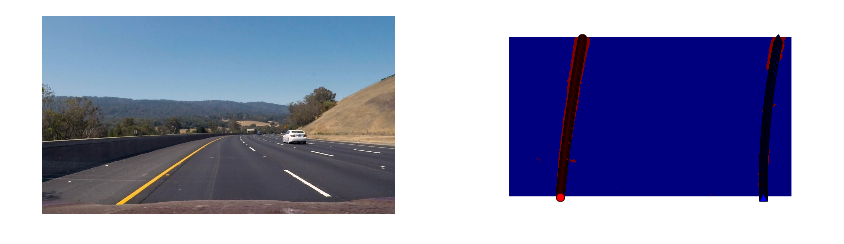

In [10]:
with open("cal_params.p", "rb") as calfile:
    mtx, dist = pickle.load(calfile)
    
with open("thresholds.p", "rb") as threshfile:
    threshold_params = pickle.load(threshfile)
    
img = mpimg.imread("test_images/test3.jpg")
top = lane_finding.pipeline(img, **threshold_params)[0]

height, width = top.shape[0], top.shape[1]

left_line, right_line = lane_finding.find_lanes(top)

# create y value array
y = np.linspace(0, height-1, height)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(img)
ax1.axis('off')

ax2.imshow(top)
ax2.plot(left_line.bestx(y), y, 'ro')
ax2.plot(right_line.bestx(y), y, 'b^')
ax2.axis('off')

## Complete Pipeline

All of the methods required to identify lane pixels and fit lines to them have been created and the corresponding thresholds have been determined at this point. Putting these together I created an end-to-end method called `process_image`.

```python
def pipeline(img,
             hue_thresh=(0,100),
             sat_thresh=(160,255),
             x_thresh=(10,255),
             y_thresh=(60,255),
             mag_thresh=(40,255),
             dir_thresh=(.65, 1.05)):
    """
    This function applies both gradient thresholding and saturation
    thresholding. A perspective transformation is then applied to the
    image. Returns binary mask of birds eye view of original image.

    :param img (ndarray): (rgb) undistorted image
    :param camera_matrix (ndarray): camera matrix
    :param distortion (ndarray): distortion parameters
    :param sat_thresh (tuple): min value, max value
    :param x_thresh (tuple): min value, max value
    :param y_thresh (tuple): min value, max value
    :param mag_thresh (tuple): min value, max value
    :param dir_thresh (tuple): min value, max value
    :return: (ndarray) birds eye binary mask of original image
    """
    # threshold saturation channel of image
    color_mask = process_color(img, hue_thresh, sat_thresh)

    # threshold gradients
    gradient_mask = process_gradients(img, x_thresh, y_thresh, mag_thresh, dir_thresh)

    # combine masks
    combine = np.zeros_like(color_mask)
    combine[(color_mask > 0) | (gradient_mask > 0)] = 1

    # apply perspective transform to mask
    src, dst = _compute_perspective_src_and_dst(img)
    perspective, M, Minv = image_utils.perspective_transform(combine, src, dst)

    # return perspective transform
    return perspective.astype(np.uint8), M, Minv


def process_image(img,
                  camera_matrix,
                  distortion,
                  left_line=None,
                  right_line=None,
                  hue_thresh=(0,100),
                  sat_thresh=(160,255),
                  x_thresh=(10,255),
                  y_thresh=(60,255),
                  mag_thresh=(40,255),
                  dir_thresh=(.65, 1.05),
                  windows=5,
                  peak_offset=50):
    """
    This is the end to end pipeline that takes a raw image and returns an image
    with the lanes drawn on it.

    :param img: (ndarray) RGB image
    :param camera_matrix: (ndarray) camera matrix
    :param distortion: (ndarray) distortion coefficents
    :param hue_thresh: (tuple) min value, max value
    :param sat_thresh: (tuple) min value, max value
    :param x_thresh: (tuple) min value, max value
    :param y_thresh: (tuple) min value, max value
    :param mag_thresh: (tuple) min value, max value
    :param dir_thresh: (tuple) min value, max value
    :param windows: (int) number of horizontal windows
    :param peak_offset: (int) minimum peak offset value
    :return:
    """
    # undistort the image using the camera matrix and distortion parameters
    undist = image_utils.undistort(img, camera_matrix, distortion)

    # filter and apply perspective tranform for birds eye view
    top, M, Minv = pipeline(undist, hue_thresh, sat_thresh, x_thresh, y_thresh, mag_thresh, dir_thresh)

    # # filter and isolate right and left lanes
    # right, left = find_lanes(top, windows, peak_offset)
    #
    # # fit 2nd order polynomial to left and right lanes
    # rpts, lpts = fit_lanes(right, left)
    left_line, right_line = find_lanes(top, left_line, right_line)

    # draw lanes on original undistorted image
    lanes = draw_lanes(undist, left_line.best_fit, right_line.best_fit, Minv)

    # annotate turn radius
    _annotate_image(lanes, left_line.radius_of_curvature)

    return lanes
```

The steps included in the pipeline are:

1. Remove camera distortions using camera matrix and distortion coefficients.
2. Create color mask by apply thresholds to hue and saturation channels in HLS colorspace.
3. Create gradient mask by applying Sobel X, Sobel Y, Magnitude, and Direction with corresponding thresholds.
4. Apply perspective transform to combined color and gradient masks.
5. Apply sliding window approach to fit lanes and compute radius of curvature.
6. Apply inverse perspective transform to fitted lane lines to return to original image space.
7. Overlay fitted lanes onto original undistorted image.
8. Annotate radius of curvature on image.

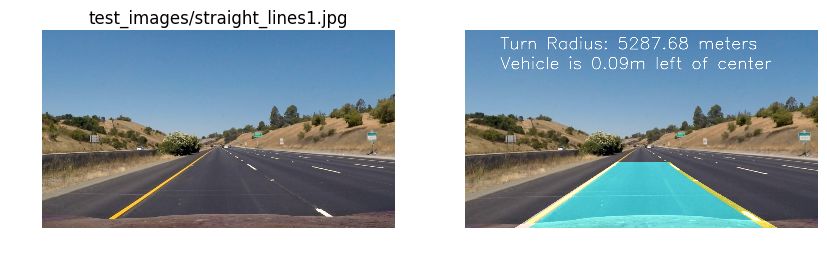

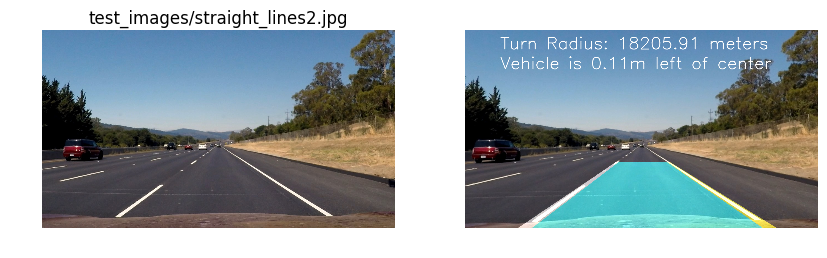

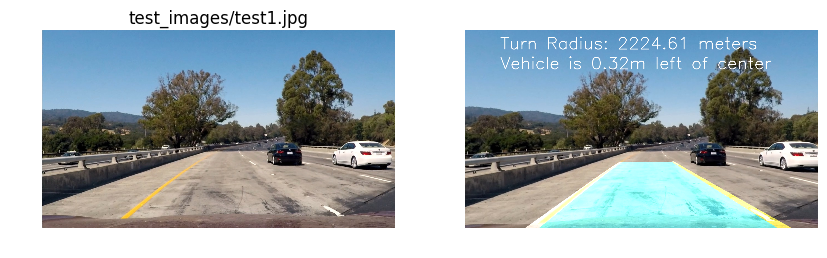

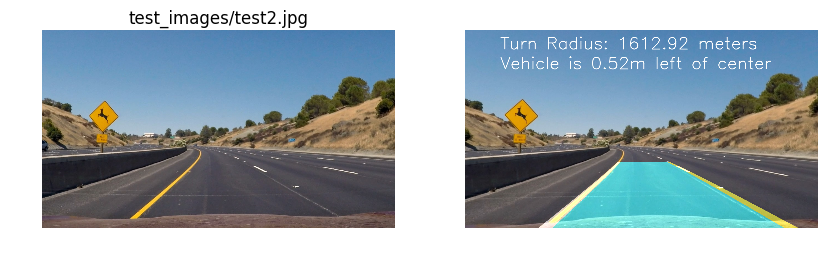

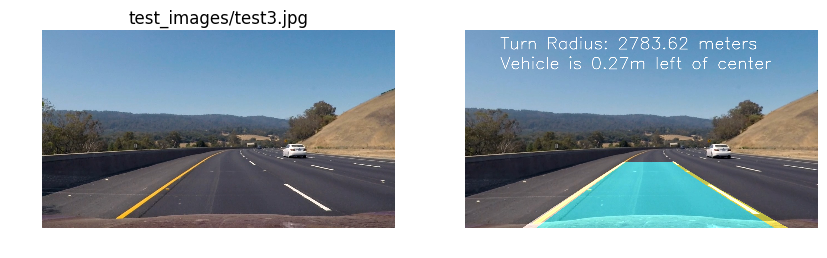

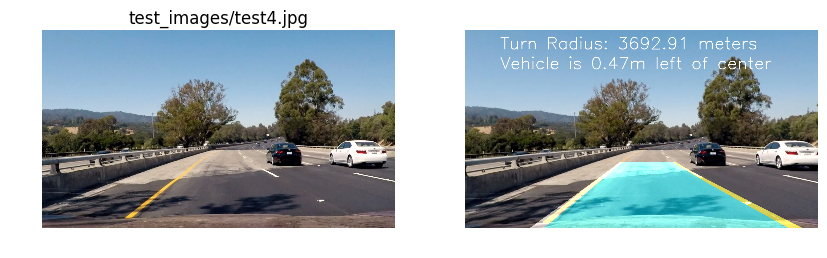

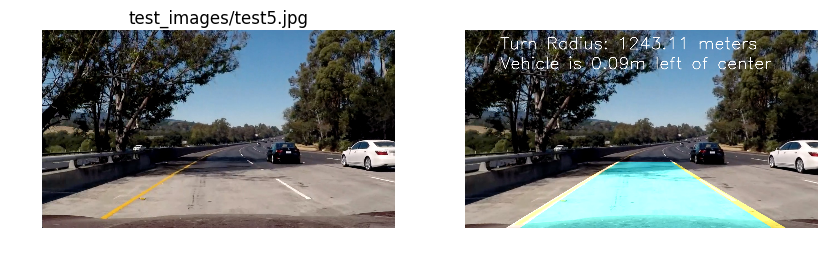

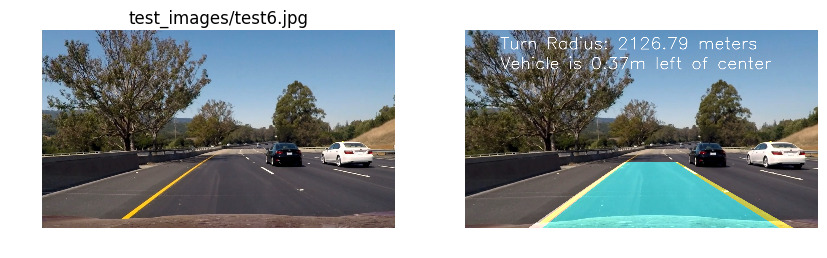

In [15]:
with open("cal_params.p", "rb") as calfile:
    mtx, dist = pickle.load(calfile)

if not os.path.exists("thresholds.p"):
    with open("thresholds.p", "wb") as thresholdfile:
        threshold_params = dict()
        threshold_params['sat_thresh'] = (95, 255)
        threshold_params['hue_thresh'] = (0, 100)
        threshold_params['x_thresh'] = (20, 255)
        threshold_params['y_thresh'] = (55, 255)
        threshold_params['mag_thresh'] = (55, 255)
        threshold_params['dir_thresh'] = (0.8, 1.10)
        pickle.dump(threshold_params, thresholdfile)
else:
    with open("thresholds.p", "rb") as thresholdfile:
        threshold_params = pickle.load(thresholdfile)

images = glob.glob("test_images/*.jpg")
for img_file in images:
    img = mpimg.imread(img_file)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.imshow(img)
    ax1.set_title(img_file)
    ax1.axis('off')
    ax2.imshow(lane_finding.process_image(img, mtx, dist, **threshold_params))
    ax2.axis('off')

## Applying Pipeline to Project Video

The final step now is to apply the pipeline to each frame of the project video. The code for accomplishing this is below. The final video submission for this project is titled "project_output.mp4" and can be found in the repository.

In [13]:
with open("cal_params.p", "rb") as f:
    mtx, dist = pickle.load(f)
    
with open("thresholds.p", "rb") as f:
    threshold_params = pickle.load(f)
    
left_line = lane_finding.Line()
right_line = lane_finding.Line()
    
# create lambda function that takes image as input and calls process_image
image_handler = lambda x: lane_finding.process_image(x, mtx, dist, left_line, right_line, **threshold_params)

# apply image handler to every frame of project video
project_output = 'project_output.mp4'
clip = VideoFileClip("project_video.mp4")
project_clip = clip.fl_image(image_handler) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False, fps=10)

  self.nchannels))



[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 504/505 [02:48<00:00,  3.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 4min 30s, sys: 30.8 s, total: 5min 1s
Wall time: 2min 50s


In [14]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Discussion

This was a challenging project that required a significant amount of time to determine the best thresholds to isolate the left and right lane pixels in the image. Lighting conditions have a significant impact and the thresholds that were determined for the project_video.mp4 do not work well with the challenge videos due to lighting conditions and debris covering the lane markings. The poor lane identification under harsh changes in lighting conditions can be compensated for by utilizing information from the prior frames to a certain extent. After doing this project I want to investigate using a deep learning approach for mask generation. Deep learning approaches have proven to be more robust than traditional thresholding strategies with the trick being that you need to make sure it is identifying what you are interested in.